# Protein Synthesis Simulation

Load dataset:

In [1]:
from HumanGenomeDataset.load_dataset import load_dataset

data_df = load_dataset('dna_protein_coding_sequences')
data_df.head(2)

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,ID,sequence,category
0,NM_001368254.1,GCTGAGCTGAGCTGGGGCGCAGCCGCCTGTCTGCACCGGCAGCACC...,NM
1,NM_001350977.1,TCCACAACTGAAACATCCACTTCTGAACACCATGTCCTACTACAGC...,NM


### Simulation

In [2]:
from src.simulation import ProteinSinthesisProcess

In [3]:
import random
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Simulation parameters
SIM_TIME = 3600*5 # 5 hours
NUMBER_RESOURCES = 475
NUMBER_RNA_POLYMERASES = 103
NUMBER_RIBOSOMES = 37
NUMBER_RNA_TRANSFER = 1700
URACIL_INITIAL_AMOUNT = random.randint(5e+4, 8e+4)
ADENINE_INITIAL_AMOUNT = random.randint(8e+4, 1e+5)
GUANINE_INITIAL_AMOUNT = random.randint(5e+4, 8e+4)
CYTOSINE_INITIAL_AMOUNT = random.randint(5e+4, 8e+4)

In [4]:
protein_synthesis_process = ProteinSinthesisProcess(
    dna_sequences_df=data_df,
    number_resources=NUMBER_RESOURCES,
    number_rna_polymerases=NUMBER_RNA_POLYMERASES, 
    number_ribosomes=NUMBER_RIBOSOMES,
    number_rna_transfers_per_codon=NUMBER_RNA_TRANSFER,
    uracil_initial_amount=URACIL_INITIAL_AMOUNT,
    adenine_initial_amount=ADENINE_INITIAL_AMOUNT,
    guanine_initial_amount=GUANINE_INITIAL_AMOUNT,
    cytosine_initial_amount=CYTOSINE_INITIAL_AMOUNT,
    random_seed=RANDOM_SEED,
    verbose=False
    )

Simulation environment initialized, time unit: 0.0001 second.


In [5]:
print(protein_synthesis_process)

Protein Sinthesis Process:
185310 dna sequences to synthesize,
205 resources available,
103 RNA polymerases,
37 ribosomes,
70952 uracil bases,
83648 adenine bases,
50819 guanine bases,
74299 cytosine bases.


In [6]:
print(repr(protein_synthesis_process))

Protein Sinthesis Process:
185310 dna sequences to synthesize,
205 resources available,
103 RNA polymerases,
37 ribosomes,
70952 uracil bases,
83648 adenine bases,
50819 guanine bases,
74299 cytosine bases,
1857 transfer RNA for UUU codon,
1587 transfer RNA for UCU codon,
1542 transfer RNA for UAU codon,
1670 transfer RNA for UGU codon,
1655 transfer RNA for UUC codon,
1644 transfer RNA for UCC codon,
1601 transfer RNA for UAC codon,
1582 transfer RNA for UGC codon,
1809 transfer RNA for UUA codon,
1574 transfer RNA for UCA codon,
1832 transfer RNA for UAA codon,
1746 transfer RNA for UGA codon,
1546 transfer RNA for UUG codon,
1545 transfer RNA for UCG codon,
1577 transfer RNA for UAG codon,
1641 transfer RNA for UGG codon,
1649 transfer RNA for CUU codon,
1788 transfer RNA for CCU codon,
1838 transfer RNA for CAU codon,
1543 transfer RNA for CGU codon,
1817 transfer RNA for CUC codon,
1631 transfer RNA for CCC codon,
1862 transfer RNA for CAC codon,
1809 transfer RNA for CGC codon,
1

Start simulation:

In [7]:
protein_synthesis_process.run(simulation_time=SIM_TIME) # run the simulation

Simulation started
End simulation: 229 proteins synthesized from 138 DNA sequences.


In [8]:
protein_synthesis_process.save_process(folder_test_name='test') # save the process

Process saved.


### Results

In [9]:
import pandas as pd
results_path = 'results/test/results.csv'

results_df = pd.read_csv(results_path, index_col=0)

In [10]:
print('Number of DNA sequence traslated:', results_df[results_df['mrna_sequences'].notna()].shape[0])
print('Number of DNA sequence not traslated:', results_df[results_df['protein_synthesized']==False].shape[0])

Number of DNA sequence traslated: 117
Number of DNA sequence not traslated: 21


In [11]:
results_df[results_df['mrna_sequences'].notna()][[
    'polypeptides_chains', 'number_of_proteins_synthesized', 'length_proteins', 'number_different_proteins']]

,polypeptides_chains,number_of_proteins_synthesized,length_proteins,number_different_proteins
1084,"['NH2-YLFPIL-COOH', 'NH2-YLFPIL-COOH', 'NH2-YL...",4,"[6, 6, 6, 6]",1.0
1534,['NH2-LLWPTRCVATGSSTLQARYATGRSVPGGGSPLS-COOH'],1,[33],1.0
3946,['NH2-PESSNSDGGTDPPTCRPQGCHRVLSCRSPIAVCPTLSHST...,2,"[213, 213]",2.0
4828,['NH2-WSPFGLLTPCFAPKLLGVSRSVRPPPP-COOH'],1,[27],1.0
6348,['NH2-GLPCRRPVRLTRTHLCS-COOH'],1,[17],1.0
...,...,...,...,...
175328,"['NH2-SYSCTTTTCGPPRRW-COOH', 'NH2-SYSCTTTTCGPP...",3,"[15, 15, 15]",1.0
175619,['NH2-TFVLLRRGRNGLPTADGRLPPGRWLVHYRVGPRPTFRWWA...,2,"[95, 95]",1.0
180004,['NH2-EGILPSMSKTGRGPGPLLGLRQLAPSPVLSSHVLVEGTGV...,1,[150],1.0
180313,['NH2-SHPSAGGRVTPTQAPRPRPLTSNLRPPLYL-COOH'],1,[30],1.0


In [12]:
results_df[results_df['mrna_sequences'].notna()][
    ['request_start_process_time', 'start_process_time', 'end_process_time',
    'number_different_proteins', 'number_of_proteins_synthesized']
    ].describe()

,request_start_process_time,start_process_time,end_process_time,number_different_proteins,number_of_proteins_synthesized
count,117.000000,117.000000,117.000000,117.000000,117.000000
mean,3072.806719,3072.806719,3304.052295,1.085470,1.957265
std,1769.521336,1769.521336,1704.849323,0.406258,1.354387
min,0.000000,0.000000,143.787900,0.000000,1.000000
25%,1525.113300,1525.113300,1874.732600,1.000000,1.000000
50%,3154.754400,3154.754400,3508.870500,1.000000,1.000000
75%,4566.524200,4566.524200,4767.494500,1.000000,2.000000
max,5985.499900,5985.499900,6089.271300,3.000000,8.000000


In [13]:
"""
statistiche su: (sono liste di valori)
'start_transcription_time', 'start_translation_time',
'end_translation_time', 'length_proteins', 'protein_synthesized'
"""

"\nstatistiche su: (sono liste di valori)\n'start_transcription_time', 'start_translation_time',\n'end_translation_time', 'length_proteins', 'protein_synthesized'\n"

### Protein Length

In [1]:
from src.utils.plot_utils import *

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


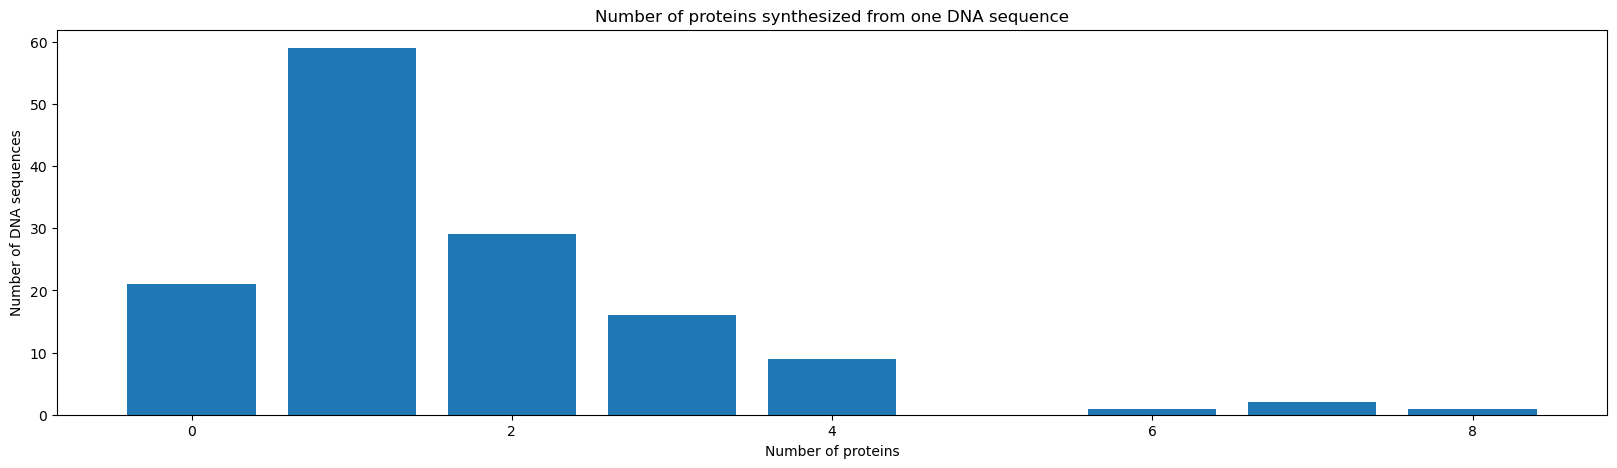

In [15]:
barplot_proteins_number(results_df)

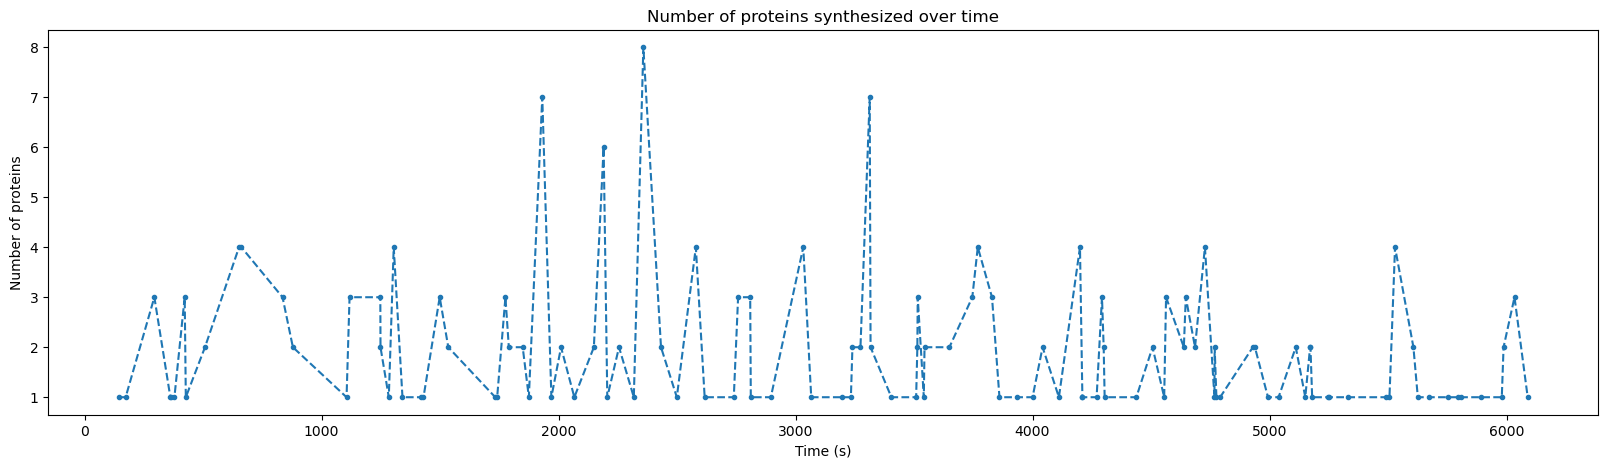

In [16]:
plot_proteins_number_over_time(results_df)

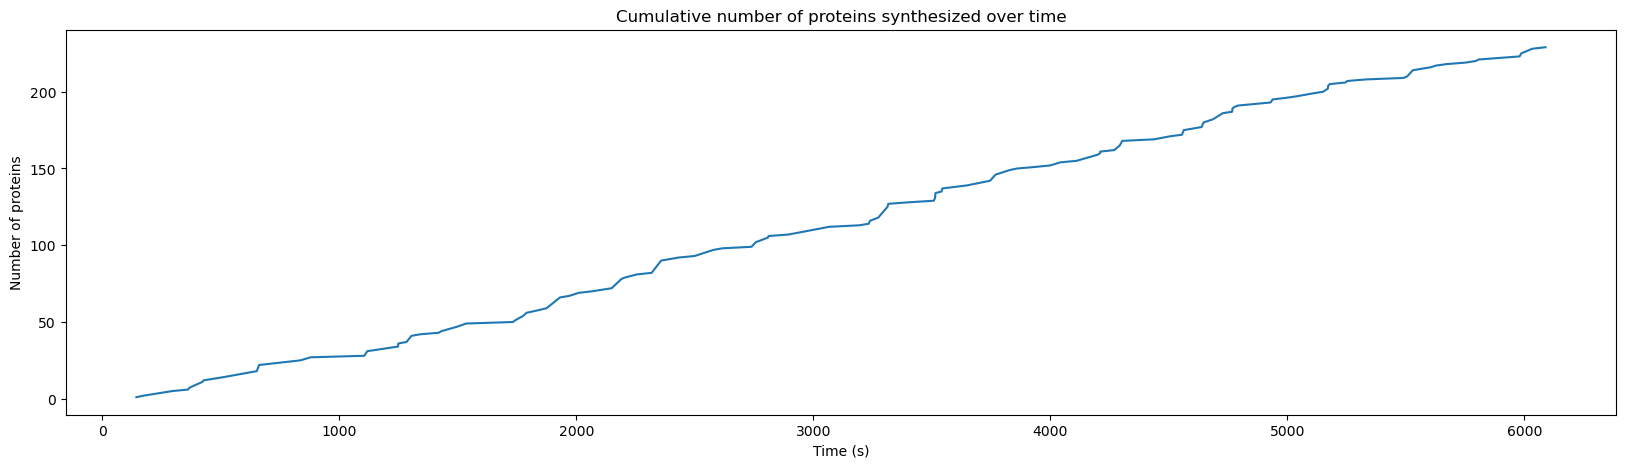

In [17]:
plot_cumulative_proteins_number_over_time(results_df)

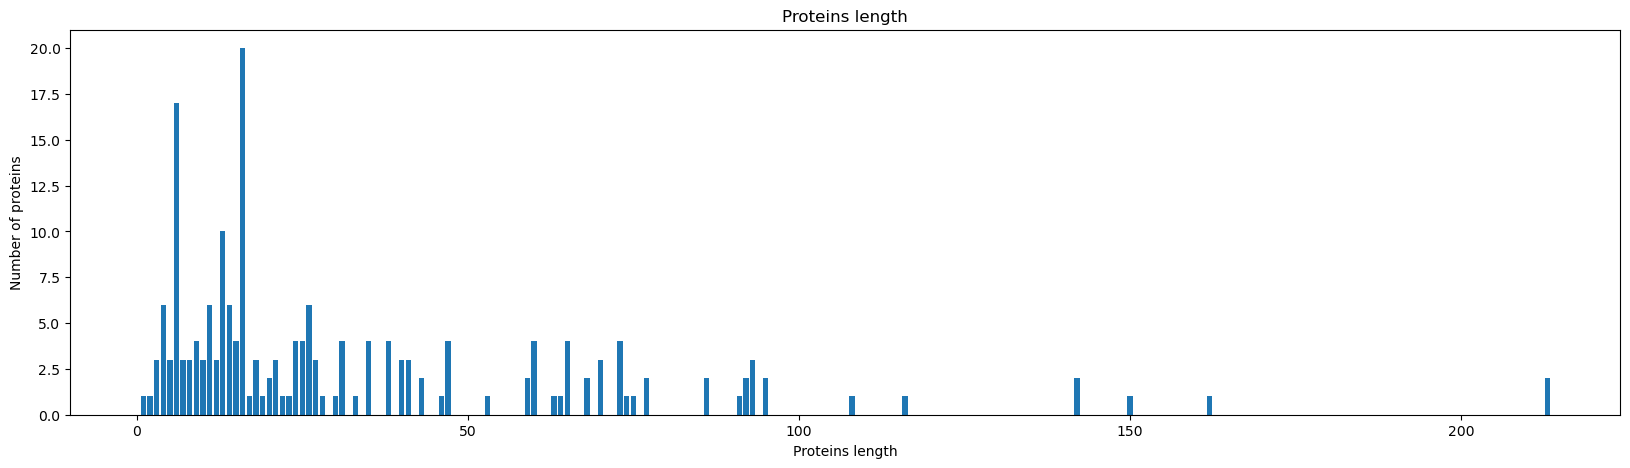

In [18]:
barplot_proteins_length(results_df)

### Nucleotides Level

In [1]:
import json

with open('results/test/nucleotides/nucleotides_history_uracil.json') as f:
    uracil_dict = json.load(f)

with open('results/test/nucleotides/nucleotides_history_adenine.json') as f:
    adenine_dict = json.load(f)

with open('results/test/nucleotides/nucleotides_history_guanine.json') as f:
    guanine_dict = json.load(f)

with open('results/test/nucleotides/nucleotides_history_cytosine.json') as f:
    cytosine_dict = json.load(f)

In [2]:
from src.utils.plot_utils import *

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [6]:
adenine_dict['level'][:100]

[83648,
 83647,
 83646,
 83645,
 83644,
 83643,
 83642,
 83641,
 83640,
 83639,
 83638,
 83637,
 83636,
 83635,
 83634,
 83633,
 83632,
 83631,
 83630,
 83629,
 83628,
 83627,
 83626,
 83625,
 83624,
 83623,
 83622,
 83621,
 83620,
 83619,
 83618,
 83617,
 83616,
 83615,
 83614,
 83613,
 83612,
 83611,
 83610,
 83609,
 83608,
 83607,
 83606,
 83605,
 83604,
 83603,
 83602,
 83601,
 83600,
 83599,
 83598,
 83597,
 83596,
 83595,
 83594,
 83593,
 83592,
 83591,
 83590,
 83589,
 83588,
 83587,
 83586,
 83585,
 83584,
 83583,
 83582,
 83581,
 83580,
 83579,
 83578,
 83577,
 83576,
 83575,
 83574,
 83573,
 83572,
 83571,
 83570,
 83569,
 83568,
 83567,
 83566,
 83565,
 83564,
 83563,
 83562,
 83561,
 83560,
 83559,
 83558,
 83557,
 83556,
 83555,
 83554,
 83553,
 83552,
 83551,
 83550,
 83549]

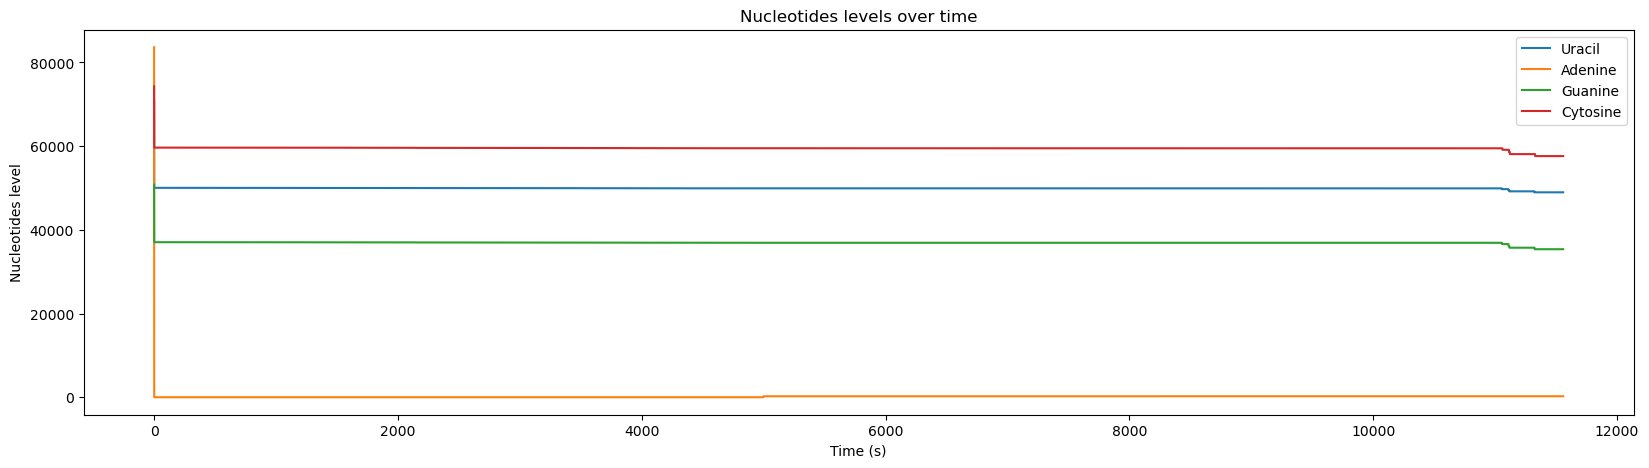

In [4]:
plot_nucleotide_level_over_time(uracil_dict, adenine_dict, guanine_dict, cytosine_dict, time_unit=1)

### RNA Polymerase

In [2]:
with open('results/test/rna_polymerase_history.json') as f:
    rna_polymerase_dict = json.load(f)

In [5]:
rna_polymerase_df = dict_to_dataframe(rna_polymerase_dict)

In [ ]:
rna_polymerase_df.describe() # values in seconds

,queue,request_time,available_time,wait_time,end_time,usage_time
count,123.0,123.000000,123.000000,123.0,123.000000,123.000000
mean,0.0,1489.154038,1489.154038,0.0,1617.364306,21.486432
std,0.0,875.209717,875.209717,0.0,894.483069,19.441096
min,0.0,0.000000,0.000000,0.0,92.143100,0.253800
25%,0.0,738.352950,738.352950,0.0,911.936700,6.530150
50%,0.0,1461.936600,1461.936600,0.0,1615.952300,16.111400
75%,0.0,2268.166750,2268.166750,0.0,2370.246900,32.599300
max,0.0,2944.667400,2944.667400,0.0,3234.902400,85.485200


### Ribosome

In [6]:
with open('results/test/ribosome_history.json') as f:
    ribosome_dict = json.load(f)

In [7]:
ribosome_df = dict_to_dataframe(ribosome_dict)

In [8]:
ribosome_df.describe()

,queue,request_time,available_time,wait_time,end_time,usage_time
count,244.0,244.000000,244.000000,244.0,244.000000,244.000000
mean,0.0,3049.957101,3049.957101,0.0,3064.665839,11.137739
std,0.0,1686.661576,1686.661576,0.0,1686.813566,5.154846
min,0.0,92.143100,92.143100,0.0,105.615100,0.078900
25%,0.0,1600.415875,1600.415875,0.0,1614.513875,7.105050
50%,0.0,3196.541500,3196.541500,0.0,3213.874950,12.629000
75%,0.0,4463.170975,4463.170975,0.0,4478.459475,14.132000
max,0.0,6076.242300,6076.242300,0.0,6089.271300,23.837000


Resources request wait time:

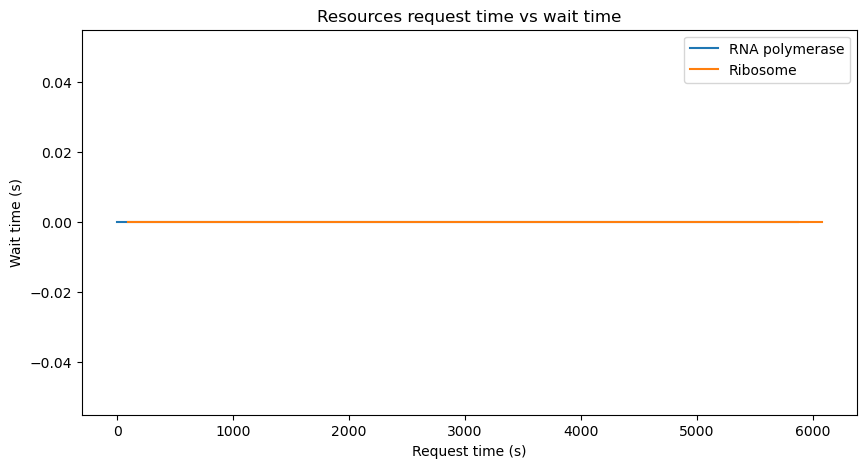

In [9]:
resources_request_wait_time(rna_polymerase_df, ribosome_df)

### Transfer RNA

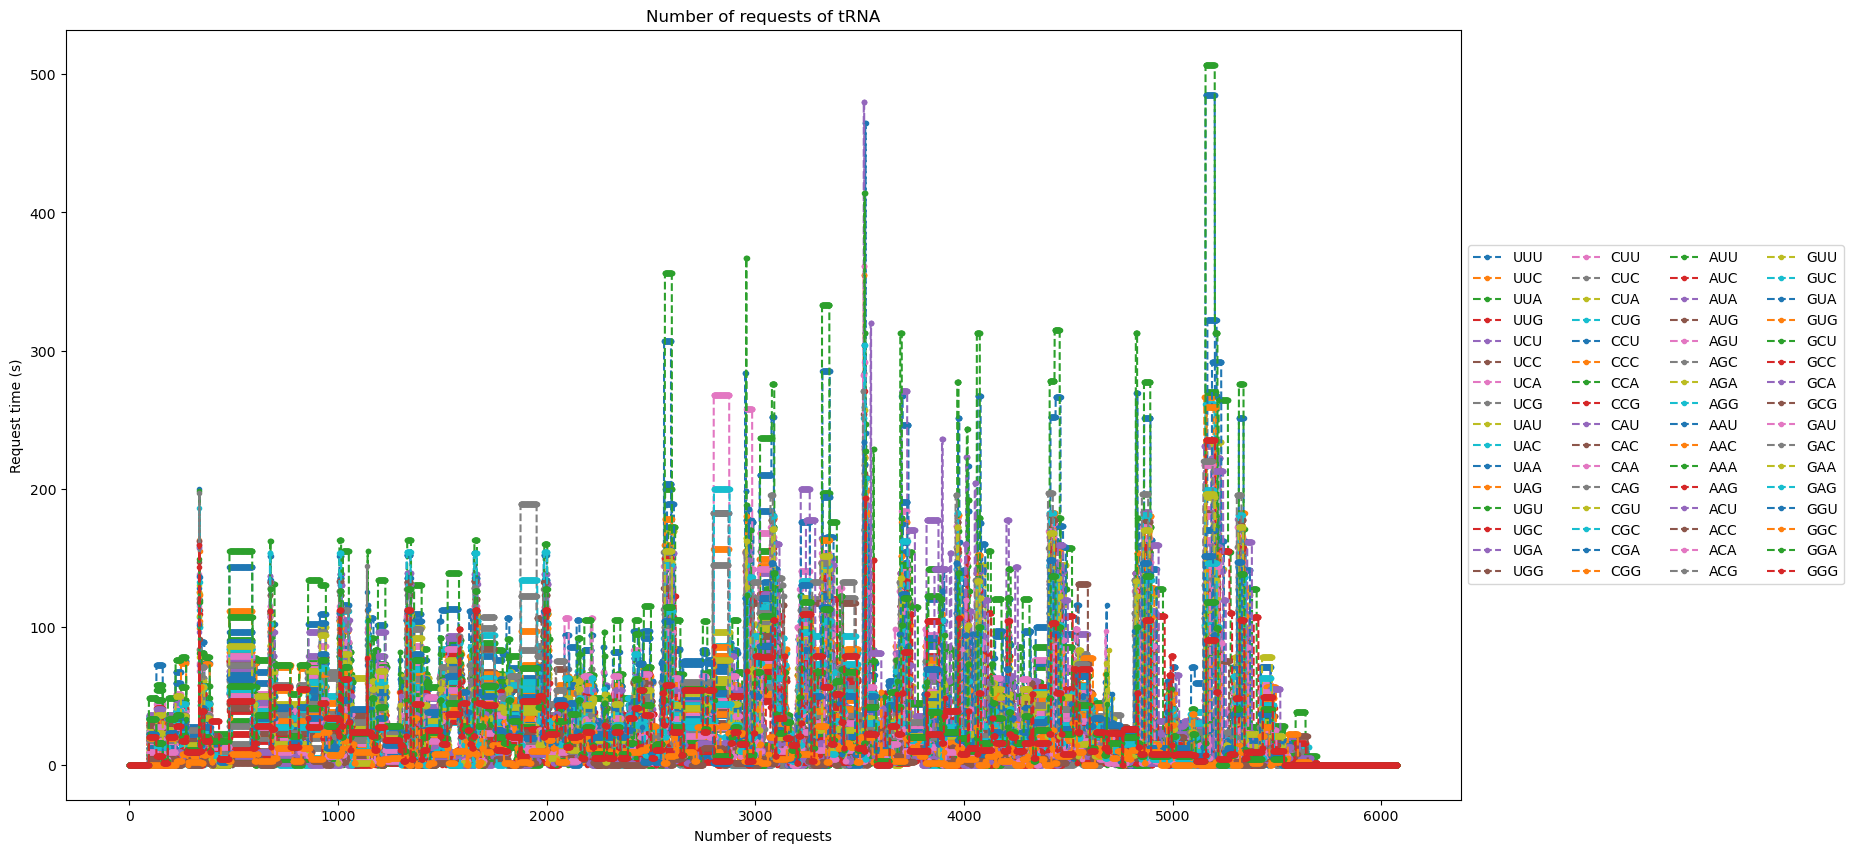

In [4]:
plot_codons_request(file_path='results/test/rna_transfer/', time_unit=1)